![image.png](attachment:image.png)

# Regressão III - Tarefa

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import patsy
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings;   warnings.filterwarnings("ignore")

In [13]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [14]:
df.shape

(750000, 13)

In [15]:
# Avaliando valores missing
df.isnull().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [16]:
# Substituindo valores missing pela média
df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
df['renda'].fillna(df['renda'].mean(), inplace=True)

# Verificando se ainda existem valores missing
df.isnull().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [17]:
df.index = pd.to_datetime(df.index)
# Separando a base teste
data_inicio = df.index.max() - pd.DateOffset(months=3)
base_teste = df[df.index > data_inicio]
# Criando base treino
base_treinamento = df[df.index <= data_inicio]

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [18]:
stm = '''np.log(renda) ~ C(sexo)
            + C(posse_de_veiculo)
            + C(posse_de_imovel)
            + qtd_filhos
            + C(tipo_renda)
            + C(educacao, Treatment(2))
            + C(estado_civil)
            + C(tipo_residencia, Treatment(1))
            + idade
            + tempo_emprego
            + qt_pessoas_residencia
            + 1'''

# Criando as matrizes de design
Y, X = patsy.dmatrices(stm, base_treinamento)

# Ajustando o modelo
modelo = sm.OLS(Y, X)
resultado = modelo.fit()

# Imprimindo o resumo do modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                 1.947e+04
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        21:06:41   Log-Likelihood:            -7.9748e+05
No. Observations:              600000   AIC:                         1.595e+06
Df Residuals:                  599975   BIC:                         1.595e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [19]:
# Categorizando a variável 'tempo_emprego' em 20 quantis
base_teste['tempo_emprego_cat'], quebras = pd.qcut(base_teste.tempo_emprego, 20, duplicates='drop', retbins=True)

# Criando a tabela de perfil
perfil = base_teste.groupby('tempo_emprego_cat').agg({'tempo_emprego': ['count', 'mean'], 'renda': lambda x: np.mean(np.log(x))}).reset_index()
perfil.columns = ['Categoria', 'Quantidade', 'Média_tempo_emprego', 'Média_log_renda']

# Exibindo a tabela de perfil
perfil

,Categoria,Quantidade,Média_tempo_emprego,Média_log_renda
0,"(0.11699999999999999, 0.827]",7601,0.520903,7.202604
1,"(0.827, 1.468]",7464,1.134215,7.257080
2,"(1.468, 2.099]",7459,1.790156,7.401755
3,"(2.099, 2.912]",7511,2.514075,7.472002
4,"(2.912, 3.636]",7507,3.299975,7.578685
5,"(3.636, 4.304]",7545,3.994033,7.660521
6,"(4.304, 4.945]",7420,4.624617,7.734648
7,"(4.945, 5.759]",7509,5.370319,7.857738
8,"(5.759, 6.622]",7492,6.203618,7.969381
9,"(6.622, 7.474]",7544,7.020387,8.037298


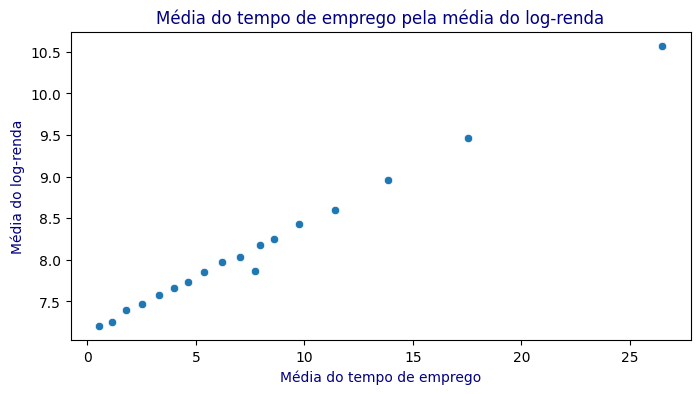

In [20]:
# Criando o gráfico de dispersão
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Média_tempo_emprego', y='Média_log_renda', data=perfil)
plt.title('Média do tempo de emprego pela média do log-renda', color = 'navy')
plt.xlabel('Média do tempo de emprego', color = 'navy')
plt.ylabel('Média do log-renda', color = 'navy')
plt.show()

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [21]:
# Aplicando a transformação logarítmica
base_teste['log_tempo_emprego'] = np.log(base_teste['tempo_emprego'] + 1)

# Definindo a fórmula para o modelo com a transformação logarítmica
stm_log = '''np.log(renda) ~ C(sexo)
            + C(posse_de_veiculo)
            + C(posse_de_imovel)
            + qtd_filhos
            + C(tipo_renda)
            + C(educacao, Treatment(2))
            + C(estado_civil)
            + C(tipo_residencia, Treatment(1))
            + idade
            + log_tempo_emprego
            + qt_pessoas_residencia
            + 1'''

In [22]:
# Ajustando o modelo com a transformação logarítmica
Y_log, X_log = patsy.dmatrices(stm_log, base_teste)
modelo_log = sm.OLS(Y_log, X_log)
resultado_log = modelo_log.fit()
print(resultado_log.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     5405.
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        21:06:47   Log-Likelihood:            -1.7921e+05
No. Observations:              150000   AIC:                         3.585e+05
Df Residuals:                  149975   BIC:                         3.587e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [23]:
# Aplicando a transformação de raiz quadrada
base_teste['sqrt_tempo_emprego'] = np.sqrt(base_teste['tempo_emprego'])

# Definindo a fórmula para o modelo com a transformação de raiz quadrada
formula_sqrt = '''np.log(renda) ~ C(sexo)
            + C(posse_de_veiculo)
            + C(posse_de_imovel)
            + qtd_filhos
            + C(tipo_renda)
            + C(educacao, Treatment(2))
            + C(estado_civil)
            + C(tipo_residencia, Treatment(1))
            + idade
            + sqrt_tempo_emprego
            + qt_pessoas_residencia
            + 1'''

# Ajustando o modelo com a transformação de raiz quadrada
Y_sqrt, X_sqrt = patsy.dmatrices(formula_sqrt, base_teste)
modelo_sqrt = sm.OLS(Y_sqrt, X_sqrt)
resultado_sqrt = modelo_sqrt.fit()
print(resultado_sqrt.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     6734.
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        21:06:51   Log-Likelihood:            -1.7111e+05
No. Observations:              150000   AIC:                         3.423e+05
Df Residuals:                  149975   BIC:                         3.425e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

Os resultados indicam que dois modelos foram avaliados: um com transformação logarítmica e outro com transformação de raiz quadrada. O R² ajustado para o modelo com transformação logarítmica é de aproximadamente 0.473, enquanto o R² ajustado para o modelo com transformação de raiz quadrada é de cerca de 0.529. Ambos os modelos conseguem explicar uma quantidade significativa da variabilidade nos dados de teste. No entanto, o modelo com a transformação de raiz quadrada apresenta um ajuste ligeiramente melhor, sugerindo que essa transformação pode ter ajudado a linearizar a relação entre tempo de emprego e renda.